In [1]:
%load_ext autoreload
%autoreload 2

from test_repo_biometric import *
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [3]:
# get the file names
train_files, test_files = train_test_all_ids('/data/home/shruti/voxceleb/vgg/leaders/')

In [4]:
# repo for only leaders
def get_train_repo1(params):
    
    out_repo = {}
    if params['istrain']:
        out_repo = build_repo(params['bsfldr'], 
                          {f: train_files[f] for f in ['bo','br','bs','cb','dt','ew','hc','jb','kh', 'pb',
                                                  'bo_imposter','bs_imposter','ew_imposter','dt_imposter',
                                                   'hc_imposter', 'jb_imposter']}, 
                          {'frames': params['frames'], 'step': params['steps'], 'pool_func': np.mean, 'N': 5000, 'n1':0, 'n2':1}, 
                          in_dict=out_repo)
    else:
        out_repo['real'] = {}; out_repo['fake'] = {}; 
        for r_or_f in ['real', 'fake']:

            out_repo[r_or_f] = build_repo(params['bsfldr'], 
                                  {f: test_files[r_or_f][f] for f in ['bo','bs','dt','ew','hc','jb']}, 
                                  {'frames': params['frames'], 'step': params['steps'], 'pool_func': np.mean, 'N': 5000, 'n1':0, 'n2':1}, 
                                          in_dict=out_repo[r_or_f])
    return out_repo


def get_result_df(vgg_repo, aus_repo, k=1):
    
    out_result_df = {}
    for r_or_f in ['real', 'fake']:

        r_or_f_res = {}
        test_keys = np.sort(['bo','bs','dt','ew','hc','jb'])
        
        for ids in test_keys:
            
            vgg_test = {}
            vgg_test = build_repo('/data/home/shruti/voxceleb/vgg/leaders/', 
                                     {ids: test_files[r_or_f][ids]}, 
                                     {'frames': 100, 'step': 5, 
                                      'pool_func': np.mean, 'N': 5000, 
                                      'n1':0.5 if 'FF_' in ids else 0, 'n2':1}, 
                                     in_dict=vgg_test)
            fabnet_test = {}
            fabnet_test = build_repo('/data/home/shruti/voxceleb/aus_corr_100/', 
                                     {ids: test_files[r_or_f][ids]}, 
                                     {'frames': 1, 'step': 1, 
                                      'pool_func': np.mean, 'N': 5000, 
                                      'n1':0.5 if 'FF_' in ids else 0, 'n2':1}, 
                                     in_dict=fabnet_test)
            
            
            cur_max, cur_pred_id = get_repo_dist(vgg_repo, vgg_test[ids], k=k)
            smpls = np.min([len(fabnet_test[ids]), len(vgg_test[ids])])
            cur_max = cur_max[:smpls].copy()
            cur_pred_id = cur_pred_id[:smpls].copy()
            
            r_or_f_res[ids] = pd.DataFrame(data=cur_max, columns=['VGG_dist'])
            r_or_f_res[ids]['predLabel'] = cur_pred_id
            r_or_f_res[ids]['actualLabel'] = ids
            r_or_f_res[ids]['RealFake'] = r_or_f
            
            fab_dist = np.zeros((smpls, ))
            for i in range(smpls):
                fab_dist[i], _ = get_repo_dist({cur_pred_id[i]: aus_repo[cur_pred_id[i]]}, 
                                            fabnet_test[ids][[i], :], k=k)
            
            r_or_f_res[ids]['AUS_dist'] = fab_dist

        out_result_df[r_or_f] = pd.concat([r_or_f_res[f] for f in test_keys], ignore_index=True, sort=False)

    return pd.concat([out_result_df[f] for f in ['real', 'fake']], ignore_index=True, sort=False)



# VGG + AUS

### Repo with only leaders + Imposters

In [5]:
# repo with leaders
vgg_repo_leaders = get_train_repo1({'istrain':True, 'bsfldr':'/data/home/shruti/voxceleb/vgg/leaders/', 
                                'frames':100, 'steps':5})

aus_repo_leaders = get_train_repo1({'istrain':True, 'bsfldr':'/data/home/shruti/voxceleb/aus_corr_100/', 
                                'frames':1, 'steps':1})


In [6]:

result_df = get_result_df(vgg_repo_leaders, aus_repo_leaders)


# Results

In [7]:
# with only leaders in repository
# if we had leaders in the repo and we get the face-swap of leaders dist
# how we do on Leader Faceswap
def get_auc(in_result_df, in_dist_name, real_nm, fake_nm):
    
    real_dist = in_result_df.loc[np.logical_and(in_result_df['actualLabel'].isin(real_nm), 
                                                in_result_df['RealFake']=='real'), in_dist_name]
    
    fake_dist = in_result_df.loc[np.logical_and(in_result_df['actualLabel'].isin(fake_nm), 
                                                in_result_df['RealFake']=='fake'), in_dist_name]
    
    fpr, tpr, thresholds = roc_curve(np.concatenate((np.ones((len(real_dist), )), 
                                                    np.zeros((len(fake_dist), )) )), 
                                     np.concatenate((real_dist, 
                                                     fake_dist)))
    return auc(fpr, tpr)
    
def plot_dist(in_result_df, in_dist_name, real_nm, fake_nm, ax, title):
    
    sns.distplot(np.log(in_result_df.loc[np.logical_and(in_result_df['actualLabel'].isin(real_nm), 
                                                in_result_df['RealFake']=='real'), in_dist_name]), 
                 bins=np.log(np.linspace(0.1, 2, 200)), label='real', ax=ax)
    sns.distplot(np.log(in_result_df.loc[np.logical_and(in_result_df['actualLabel'].isin(fake_nm), 
                                                in_result_df['RealFake']=='fake'), in_dist_name]), 
                 bins=np.log(np.linspace(0.1, 2, 200)), label='fake', ax=ax)
    ax.set_title(title)
    ax.set_xlim([np.log(0.1), np.log(2)])
    ax.legend()

### AUC results



#### 

In [11]:
# remove nan
result_df_no_nan = result_df.dropna()

In [13]:
print('Repo Leaders')
print('\t VGG')

print('\t \t leaders {0:0.4f}'.format(get_auc(result_df_no_nan, 'VGG_dist', 
                                              ['bo','bs','dt','ew','hc','jb'], 
                                              ['bo','bs','dt','ew','hc','jb'])))

print('\t AUS')
print('\t \t leaders {0:0.4f}'.format(get_auc(result_df_no_nan, 'AUS_dist', 
                                              ['bo','bs','dt','ew','hc','jb'], 
                                              ['bo','bs','dt','ew','hc','jb'])))

print('\t VGG + AUS')
result_df_no_nan['VGG_AUS_dist'] = np.array(result_df_no_nan['VGG_dist']) + np.array(result_df_no_nan['AUS_dist'])
print('\t \t leaders {0:0.4f}'.format(get_auc(result_df_no_nan, 'VGG_AUS_dist', 
                                              ['bo','bs','dt','ew','hc','jb'], 
                                              ['bo','bs','dt','ew','hc','jb'])))


Repo Leaders
	 VGG
	 	 leaders 0.9146
	 AUS
	 	 leaders 0.7133
	 VGG + AUS
	 	 leaders 0.7590


/data/opt/voxceleb/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Distributions

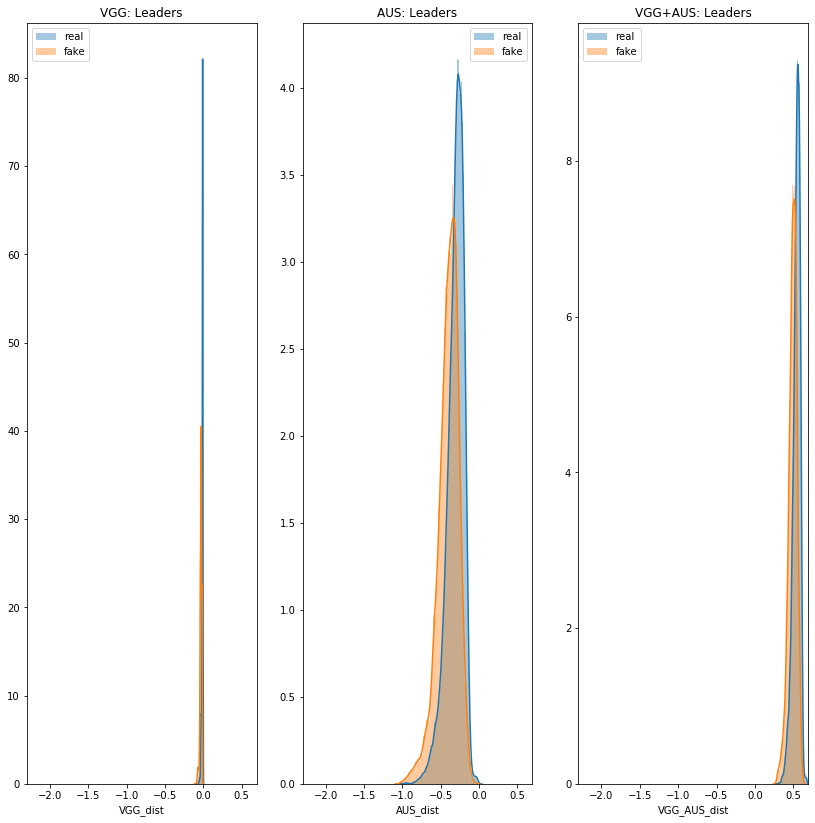

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,14))

plot_dist(result_df_no_nan, 'VGG_dist', ['bo','bs','dt','ew','hc','jb'], 
          ['bo','bs','dt','ew','hc','jb'], 
          ax[0], 'VGG: Leaders')

plot_dist(result_df_no_nan, 'AUS_dist', ['bo','bs','dt','ew','hc','jb'], 
          ['bo','bs','dt','ew','hc','jb'], 
          ax[1], 'AUS: Leaders')

plot_dist(result_df_no_nan, 'VGG_AUS_dist', ['bo','bs','dt','ew','hc','jb'], 
          ['bo','bs','dt','ew','hc','jb'], 
          ax[2], 'VGG+AUS: Leaders')

plt.subplots_adjust(hspace=0.3)